In [1]:
import h5py # for working with HDF5 (Hierarchical Data Format) files
import numpy as np
import sklearn.svm
import matplotlib.pyplot as plt
import pandas as pd
import os
from V3.load_calcium_video import load_video_data
from V3.align_behavior_to_calcium import align_files
from V3.class_balance import check_class_imbalance

In [2]:
comment = "k-fold-cross validation, multiple videos, new labels"
experiment_ID = '3.2'
data_file = 'Animal3learnday8, Animal3Learnday9, Animal3Learnday10'
experiment_name = str(data_file)+"_"+str(experiment_ID)
train_test_split_strategy = "k-fold"
name = 'BPSVM'
model_version = str(name)+'_1'

%store experiment_ID

Stored 'experiment_ID' (str)


In [3]:
# Define the name of the output directory
output_dir = "output-svm"

# Check if the output directory already exists
if not os.path.exists(output_dir):
    # Create the output directory
    os.mkdir(output_dir)

    # Create the balance, accuracy, loss, and cm directories inside the output directory
    os.mkdir(os.path.join(output_dir, "balance"))
    os.mkdir(os.path.join(output_dir, "accuracy"))
    os.mkdir(os.path.join(output_dir, "loss"))
    os.mkdir(os.path.join(output_dir, "cm"))
    os.mkdir(os.path.join(output_dir, "architecture"))
    os.mkdir(os.path.join(output_dir, "pickles"))
else:
    print(f"The directory {output_dir} already exists.")

The directory output-svm already exists.


### Loading Calcium Videos

In [4]:
# paths to videos
video_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.nwb", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.nwb", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.nwb"]

In [5]:
# load the CSV file with the FOV information
fov_info = pd.read_csv('/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/aligned_videos_animal3.csv')

In [6]:
video_name_list = []
video_data_list = []

images = load_video_data(video_paths, fov_info, video_name_list, video_data_list)

20211025_184906_animal3learnday8.nwb recording_20211025_184906-PP-BP-MC
20211025_184906_animal3learnday8.nwb is cropped
(24479, 356, 398)
20211026_142935_animal3learnday9.nwb recording_20211026_142935-PP-BP-MC
20211026_142935_animal3learnday9.nwb is cropped
(24434, 356, 398)
20211027_165052_animal3learnday10.nwb recording_20211027_165052-PP-BP_001-MC
20211027_165052_animal3learnday10.nwb is cropped
(24456, 356, 398)
Concatenated video shape: (73369, 356, 398)


In [7]:
images[0].shape

(356, 398)

In [8]:
# Check if the video has been loaded correctly
images[:1]

array([[[175, 172, 164, ..., 157, 163, 172],
        [167, 167, 168, ..., 164, 158, 166],
        [171, 170, 167, ..., 161, 155, 160],
        ...,
        [172, 156, 151, ..., 171, 166, 167],
        [163, 162, 157, ..., 167, 163, 170],
        [146, 162, 160, ..., 161, 161, 160]]], dtype=int16)

In [9]:
# Determine the size of the calcium video dataset
num_of_frames = images.shape[0]
img_height = images.shape[1]
img_width = images.shape[2]
print("The number of video frames is ", num_of_frames, " and the frame dimensions (height x width) are: ", img_height, "X", img_width)

The number of video frames is  73369  and the frame dimensions (height x width) are:  356 X 398


In [10]:
### Loading Bonsai and Behavior file

In [11]:
# # paths to videos
# num_of_videos = 3

# bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]

In [12]:
# # paths to videos
# behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
#                "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

In [13]:
path = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/animal3.h5"

In [14]:
list_of_traces = []
with (h5py.File(path, 'r')) as f:
    traces_8 = np.array(f['traces/animal3learnday8/deconvolved'])
    list_of_traces.append(traces_8)
    traces_9 = np.array(f['traces/animal3learnday9/deconvolved'])
    list_of_traces.append(traces_9)
    traces_10 = np.array(f['traces/animal3learnday10/deconvolved'])
    list_of_traces.append(traces_10)

In [15]:
traces = np.concatenate(list_of_traces, axis=1)
print("Concatenated traces shape:", traces.shape)

Concatenated traces shape: (110, 73369)


In [16]:
# # traces[50]
# row = 40  # Select the row to plot
# start = 0  # Starting index of the plot
# end = 50  # Ending index of the plot

# plt.plot(traces_8[row, start:end])
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.title(f'Trace {row+1} (indices {start}-{end})')
# plt.show()

In [17]:
# paths to videos
num_of_videos = 3

bonsai_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-25T18_48_49.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-26T14_29_27.csv", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-27T16_50_53.csv"]

In [18]:
# paths to videos
behavior_paths = ["/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211025_184906_animal3learnday8.h5", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211026_142935_animal3learnday9.h5", 
               "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211027_165052_animal3learnday10.h5"]

In [19]:
df_new_annotations, df_new_annotations_unique = align_files(bonsai_paths, behavior_paths, num_of_videos)

/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/align_behavior_to_calcium.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_annotations.loc[:, 'state_id'] = df_new_annotations.loc[:, 'state_id'].replace(state_id_map)
/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/V3/align_behavior_to_calcium.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [20]:
# # paths to videos
# num_of_videos = 1

# bonsai_data = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/tmaze_2021-10-28T18_13_23.csv"
# # paths to videos
# behavior_paths = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/data/20211028_181307_animal3learnday11.h5"

# bonsai_data = pd.read_csv(bonsai_data, header=None)

# df_behavior = pd.read_hdf(behavior_paths, 'per_frame')

In [21]:
# # Adding column names
# bonsai_data = bonsai_data.rename(columns={
#     0: 'Time', 1: 'Trial_Number',
#     2: 'Reward', 3: 'Frame_Number', 4: 'Central_Zone',
#     5: 'L_Zone', 6: 'R_Zone', 7: 'Calcium_frame'})

In [22]:
# df_aligned = df_behavior.loc[bonsai_data.groupby('Calcium_frame').first()[1:].Frame_Number].reset_index()

In [23]:
# df_new_annotations = df_aligned[['state_id', 'state_name']]

# df_unique_states = df_new_annotations[['state_id', 'state_name']].drop_duplicates(subset='state_id').set_index('state_id')['state_name'].sort_index()

In [24]:
# df_unique_states

In [25]:
# # state id mapping for main corridor, left corridor, right corridor
# state_id_map = {
#     1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0,
#     9: 1, 11: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1,
#     10: 2, 12: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2,
# }

In [26]:
# #     # state_id map for forward, left turn, right turn, 
# #     state_id_map = {
# #         #forward
# #         0: 0, 3: 0, 4: 0, 5: 0, 6: 0, 13: 0, 14: 0, 15: 0, 19: 0, 20: 0, 21: 0, 

# #         #left
# #         1: 1, 7: 1, 9: 1, 11: 1, 16: 1, 18: 1, 22: 1, 

# #         #right
# #         2: 2, 8: 2, 10: 2, 12: 2, 17: 2, 23: 2, 24: 2
# #     }


# df_new_annotations.loc[:, 'state_id'] = df_new_annotations.loc[:, 'state_id'].replace(state_id_map)
# df_new_annotations = df_new_annotations.loc[:, 'state_id']    

# # return df_new_annotations, df_unique_states

In [27]:
df_new_annotations = df_new_annotations.loc[:, 'state_id']    

In [28]:
df_new_annotations

0        0
1        0
2        0
3        0
4        0
        ..
73364    2
73365    2
73366    2
73367    2
73368    2
Name: state_id, Length: 73369, dtype: int64

In [29]:
df_new_annotations_unique = df_new_annotations.unique()

In [30]:
df_new_annotations_unique

array([0, 1, 2])

In [31]:
save_dir = "/home/dmc/Desktop/kostas/direct-Behavior-prediction-from-miniscope-calcium-imaging-using-convolutional-neural-networks/src/output-svm/balance"

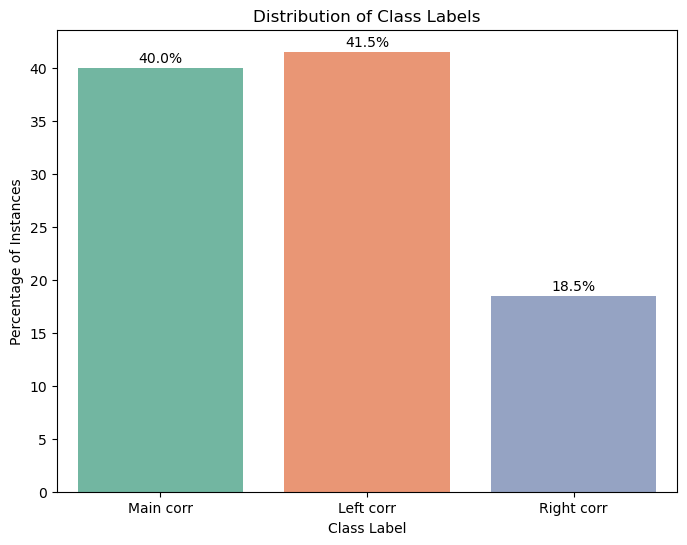

In [32]:
class_counts, total_counts = check_class_imbalance(df_new_annotations, experiment_ID, save_dir)

In [33]:
# Training Parameters
channel_dimension = 1
labels = df_new_annotations
epochs = 1
# batch_size = 8

In [34]:
# traces[50]
# row = 40  # Select the row to plot
# start = 0  # Starting index of the plot
# end = 50  # Ending index of the plot

# plt.plot(traces_8[row, start:end])
# plt.xlabel('Sample Index')
# plt.ylabel('Amplitude')
# plt.title(f'Trace {row+1} (indices {start}-{end})')
# plt.show()

In [35]:
# plt.plot(traces_8[40, 450:500])


In [42]:
mySVC = sklearn.svm.LinearSVC()
# mySVC.fit(traces.T, df_new_annotations)
# mySVC.predict(traces.T)

## Perform k-fold cross validation

In [37]:
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.svm import LinearSVC

# # Define the number of folds for cross-validation
# n_folds = 10

# # Create a LinearSVC object
# mySVC = LinearSVC()

# # Create a KFold object for splitting the data into folds
# kf = KFold(n_splits=n_folds)

# # Perform cross-validation and get the scores
# scores = cross_val_score(mySVC, traces.T, df_new_annotations, cv=kf) # traces.T is X and df_new_annotations is y

# # Print the mean score and standard deviation
# print("Cross-validation scores:", scores)
# print("Mean score:", scores.mean())
# # print("Standard deviation:", scores.std())

In [38]:
# mySVC = sklearn.svm.LinearSVC()

In [39]:
# mySVC.fit(traces.T, df_new_annotations)

In [40]:
# mySVC.predict(traces.T)

In [43]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.svm import LinearSVC


mySVC.fit(traces.T, df_new_annotations)
mySVC.predict(traces.T)

mySVC = LinearSVC()

kf = KFold(n_splits=10)

y_pred = cross_val_predict(mySVC, traces.T, df_new_annotations, cv=kf)

accuracy = accuracy_score(df_new_annotations, y_pred)
print("Average accuracy:", accuracy)

y_pred_prob = cross_val_predict(mySVC, traces.T, df_new_annotations, cv=kf, method='decision_function')
log_loss_avg = log_loss(df_new_annotations, y_pred_prob)
print("Average log loss:", log_loss_avg)

cm_avg = confusion_matrix(df_new_annotations, y_pred)
print("Confusion matrix:")
print(cm_avg)


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/

Average accuracy: 0.4636290531423353


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/dmc/

Average log loss: 8.66066872111212
Confusion matrix:
[[18441  7832  3080]
 [13913 12679  3856]
 [ 6769  3903  2896]]


/home/dmc/anaconda3/envs/new_kostas_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
